# XGboost

In [345]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

target_path = "order_book_target.parquet"
feature_path = "order_book_feature.parquet"

df_target = pd.read_parquet(target_path)
df_feature = pd.read_parquet(feature_path)

spy_data = df_feature[df_feature['stock_id'] == 50200]

print(spy_data.head())


          stock_id  time_id  seconds_in_bucket  bid_price1  ask_price1  \
13501269     50200       12                1.0      370.62      370.64   
13501270     50200       12                2.0      370.68      370.70   
13501271     50200       12                3.0      370.66      370.69   
13501272     50200       12                4.0      370.75      370.77   
13501273     50200       12                5.0      370.79      370.83   

          bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
13501269      370.61      370.65        100        100        200         63  
13501270      370.67      370.71          7        100        257        200  
13501271      370.64      370.70        200        100        100        300  
13501272      370.74      370.78        100        100        200        100  
13501273      370.78      370.84        557        400        500        300  


## Feature Engineering


In [347]:
def compute_orderbook_features(spy_data):
    spy_data = spy_data.copy()

    spy_data['mid_price'] = (spy_data['bid_price1'] + spy_data['ask_price1']) / 2
    spy_data['wap'] = (spy_data['bid_price1'] * spy_data['ask_size1'] + spy_data['ask_price1'] * spy_data['bid_size1']) / (
        spy_data['bid_size1'] + spy_data['ask_size1']
    )
    spy_data['bid_ask_spread'] = spy_data['ask_price1'] - spy_data['bid_price1']
    spy_data['spread_pct'] = spy_data['bid_ask_spread'] / spy_data['mid_price']
    spy_data['spread_variation'] = spy_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )
    spy_data['imbalance'] = (spy_data['bid_size1'] - spy_data['ask_size1']) / (spy_data['bid_size1'] + spy_data['ask_size1'])
    spy_data['depth_ratio'] = spy_data['bid_size1'] / spy_data['ask_size1'].replace(0, np.nan)

    spy_data['wap_lag1'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].shift(1)
    spy_data['wap_return'] = (spy_data['wap'] - spy_data['wap_lag1']) / spy_data['wap_lag1']
    spy_data['log_return'] = np.log(spy_data['wap'] / spy_data['wap_lag1'].replace(0, np.nan))

    spy_data['wap_mean_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean())
    spy_data['wap_std_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std())

    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'wap_lag1', 'wap_return', 'log_return',
        'wap_mean_10', 'wap_std_10',
        'spread_pct', 'spread_variation',
        'imbalance','depth_ratio'
    ]
    return spy_data[keep_cols]




## baseline


In [349]:
spy_feat = compute_orderbook_features(spy_data)

def realized_volatility(series):
    return np.sqrt(np.sum(np.square(np.diff(np.log(series)))))

rv_df = spy_feat.groupby("time_id")["wap"].apply(realized_volatility).reset_index()
rv_df.columns = ["time_id", "rv"]

feature_agg_base = spy_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
})
feature_agg_base.columns = ['_'.join(col) for col in feature_agg_base.columns]
feature_agg_base = feature_agg_base.reset_index()

data = pd.merge(feature_agg_base, rv_df, on="time_id", how="inner")


### test and train

In [351]:
# 5. train and test
data = data.sort_values(by="time_id")
unique_ids = sorted(data["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = data[data["time_id"].isin(train_ids)]
test_df = data[data["time_id"].isin(test_ids)]
X_train = train_df.drop(columns=["time_id", "rv"])
y_train = train_df["rv"]
X_test = test_df.drop(columns=["time_id", "rv"])
y_test = test_df["rv"]

 Chronological 80/20 Split Evaluation:
MSE: 1.4202712968983787e-07
R²:  0.7597
QLIKE: -5.647806


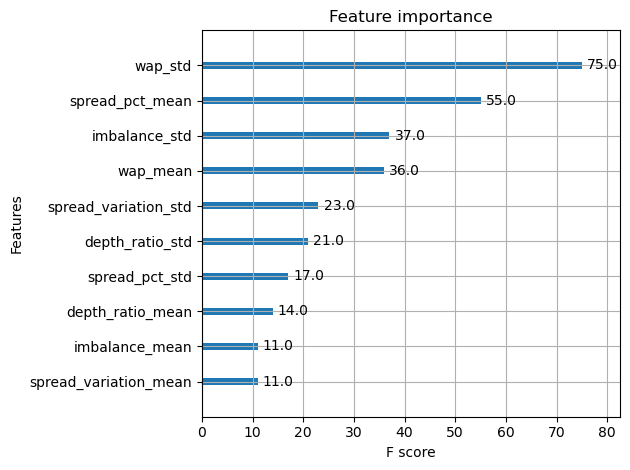

In [352]:

# XGBoost
model1 = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model1.fit(X_train, y_train)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None) 
    return np.mean(np.log(y_pred) + (y_true / y_pred))


y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print(" Chronological 80/20 Split Evaluation:")
print(f"MSE: {mse}")
print(f"R²:  {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

plot_importance(model1)
plt.tight_layout()
plt.show()

## add more feature 

In the Add Feature model stage, using additional engineered features, including:

- wap_std_10_mean  
- wap_std_10_std   
- wap_return_max  
- spread_pct_mean


In [355]:
feature_agg = spy_feat.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std', 'max', 'min'],
    'depth_ratio': ['mean', 'std'],
    'wap_return': ['mean',  'max', 'min', 'skew'],
    'log_return': ['mean',  'max', 'min', 'skew'],
    'wap_mean_10': ['mean', 'std'],
    'wap_std_10': ['mean', 'std']
})

feature_agg.columns = ['_'.join(col) for col in feature_agg.columns]
feature_agg = feature_agg.reset_index()

data_2 = pd.merge(feature_agg, rv_df, on="time_id", how="inner")


In [356]:
# 5. train and test

data_2 = data_2.sort_values(by="time_id")
unique_ids = sorted(data_2["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df = data_2[data_2["time_id"].isin(train_ids)]
test_df = data_2[data_2["time_id"].isin(test_ids)]
X_train = train_df.drop(columns=["time_id", "rv"])
y_train = train_df["rv"]
X_test = test_df.drop(columns=["time_id", "rv"])
y_test = test_df["rv"]

 Chronological 80/20 Split Evaluation:
MSE: 1.4893651819101912e-08
R²:  0.9748
QLIKE: -5.678672


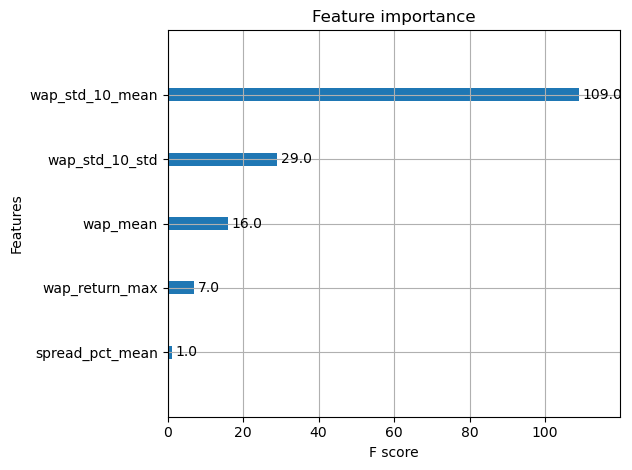

In [357]:

# XGBoost
model2 = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model2.fit(X_train, y_train)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None)  
    return np.mean(np.log(y_pred) + (y_true / y_pred))


y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print(" Chronological 80/20 Split Evaluation:")
print(f"MSE: {mse}")
print(f"R²:  {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

plot_importance(model2)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

### depth and weight

In [360]:
model_better = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=100000000000)
model.fit(X_train, y_train)

param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=model_better,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best Parameters: {'max_depth': 2, 'min_child_weight': 5}
Best Score: -5.825018800171017e-08


### gamma

In [362]:
# Use the current best max_depth and min_child_weight to validate
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    random_state=100000000000
)

# Define the range for gamma
param_grid = {
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print("Best gamma:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best gamma: {'gamma': 0}
Best score: -5.825018800171017e-08


### subsample and colsample_bytree

In [364]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    gamma=0,
    random_state=100000000000
)

# the range for subsample and colsample_bytree
param_grid = {
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.8}
Best score: -5.285200151276557e-08


In [365]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    min_child_weight=5,
    gamma=0,
    subsample=1.0,
    colsample_bytree=0.0,
    random_state=42
)

param_grid = {
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1],   # L1 regularization
    'reg_lambda': [0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.5]  # L2 regularization
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best regularization parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best regularization parameters: {'reg_alpha': 0.001, 'reg_lambda': 0.7}
Best score: -1.9818422353869295e-07


### final model

In [367]:
final_model = XGBRegressor(
    learning_rate=0.05,
    n_estimators=300,  # add more tree num to make up for learning rate
    max_depth=2,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.001,
    reg_lambda=0.7,
    random_state=100000000000
)

# final model
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
qlike_score = qlike(y_test, y_pred)

print("the final output：")
print(f"MSE: {mse:.8f}")
print(f"R² : {r2:.4f}")
print(f"QLIKE: {qlike_score:.6f}")

the final output：
MSE: 0.00000001
R² : 0.9760
QLIKE: -5.677951


## Visualization

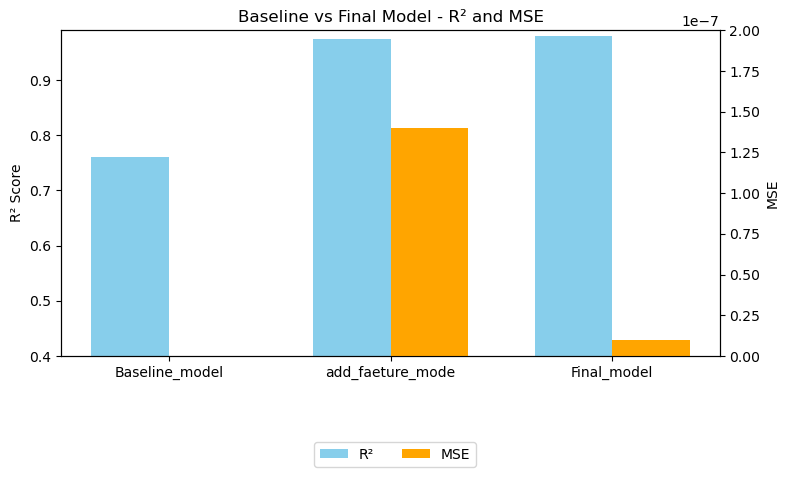

In [369]:

models = ['Baseline_model', 'add_faeture_mode','Final_model']
r2_scores = [0.7597, 0.9748,0.9790]
mse_scores = [0.00000000, 0.00000014,0.00000001]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 4))


bar1 = ax1.bar(x - width/2, r2_scores, width, label='R²', color='skyblue')
ax1.set_ylabel('R² Score')
ax1.set_ylim(0.40, 0.99)
ax1.set_title('Baseline vs Final Model - R² and MSE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)


ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, mse_scores, width, label='MSE', color='orange')
ax2.set_ylabel('MSE')
ax2.set_ylim(0, 0.0000002)


fig.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()


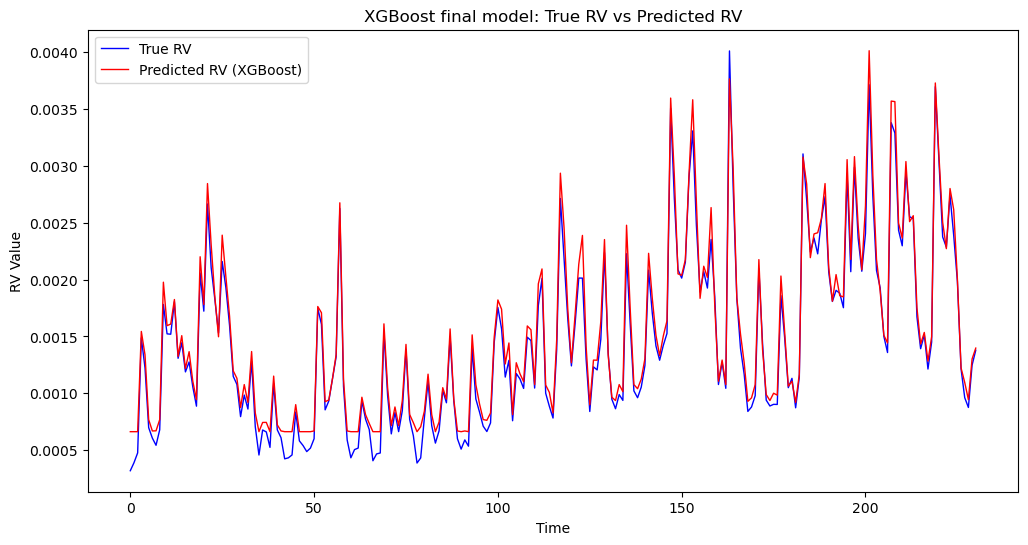

In [370]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True RV', color='blue', linewidth=1)
plt.plot(y_pred, label='Predicted RV (XGBoost)', color='red', linewidth=1)
plt.title('XGBoost final model: True RV vs Predicted RV')
plt.xlabel('Time')
plt.ylabel('RV Value')
plt.legend()
plt.show()
